In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import sys
sys.path.append('/home/chenani/ownCloud/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/')

In [3]:
import signale
import numpy as np
import matplotlib.pyplot as pl
import spectrum as sp
import cPickle as pkl
import scipy.signal as scsig
import pywt
import colormaps as mycmps
import signale.tools as tools
import os
import itertools
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from matplotlib.mlab import  PCA as mlabPCA
from mtspec import mtspec

/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/chenani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


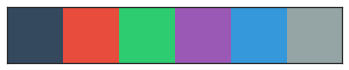

In [130]:
sns.set_context("poster",font_scale=1.7)
flatui = sns.color_palette([  "#34495e","#e74c3c", "#2ecc71","#9b59b6", "#3498db", "#95a5a6"])
sns.palplot(flatui)
sns.set_style('white')
sns.set_palette(flatui)
kr = np.array(['k','r'])
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
seabC = sns.xkcd_palette(colors)
colorsss = ['#FF0000', '#0000FF', '#008000', '#00FFFF', '#FF00FF', '#EE82EE',
        '#808000', '#800080', '#FF6347', '#FFFF00', '#9ACD32', '#4B0082',
        '#FFFACD', '#C0C0C0', '#A0522D', '#FA8072', '#FFEFD5', '#E6E6FA',
        '#F1FAC1', '#C5C5C5', '#A152ED', '#FADD72', '#F0EFD0', '#EEE6FF',
        '#01FAC1', '#F5F5F5', '#A152FF', '#FAFD72', '#F0EFDF', '#EEEFFF',
        '#F1FA99', '#C9C9C9', '#A152DD', '#FA5572', '#FFFFD0', '#EDD6FF']
def zScore(array):
    return(array - np.average(array))/ np.std(array)
clPalette = sns.color_palette('deep')

In [123]:
animalPath = '/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3838/'
dataFolder = '/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/lesion/Rat3838Lesion/dataFiles/sleepDB/'
freqz = pkl.load(open('/home/chenani/ownCloud/IpythonNotebooks/Sleep/MEC_Lesion_Project/files/freqZ.nparr','rb'))
animal = dataFolder.split('/')[-4]
rippDB = pd.read_pickle(dataFolder+ 'Rat3838-RipplesTimeDB-SKLRN.pd')
rippPSD = pkl.load(open(dataFolder+'Rat3838rippPSD-mtm.npArr','rb'))
whiteRippPSD = pkl.load(open(dataFolder+'Rat3838whiteRippPSD-mtm.npArr','rb'))
rippSignal = pkl.load(open(dataFolder + 'Rat3838rippSignal.npArr','rb'))

LinearTrack_02-01-16_Day1
10.0
LinearTrack_02-02-16_Day2
10.0
LinearTrack_02-03-16_Day3
10.0
LinearTrack_02-04-16_Day4
10.0


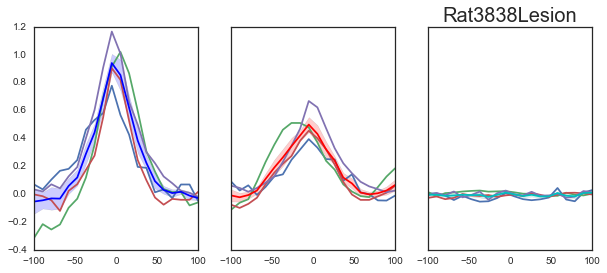

In [124]:
taxis = np.linspace(-100,100,20)
f,(ax,bx,cx) = pl.subplots(1,3,figsize=[10,4],sharey=True)
SWR_mean = []
FGB_mean = []
RND_mean = []
for ii,spkFile in enumerate(sorted([os.path.join(item[0],item[1]) for item in tools.locate('FiringUnits.spk',animalPath)])[:]):
    print spkFile.split('/')[-3]
    spk = pkl.load(open(spkFile,'rb'))
    spk.changeTimeUnit('ms')
    t_bins = np.arange(0,np.math.ceil(spk.t_stop),10)
    binWidth = np.diff(t_bins)[0]
    print binWidth
    hst = np.zeros(t_bins.size-1)
    for zug in spk:
        hst += np.histogram(zug.spike_times,t_bins)[0]
    fRate = zScore(1e3*hst/binWidth)
    df = rippDB[rippDB.date=='day'+str(ii+1)]
    dfR = df[df.wc==300]
    dfG = df[df.wc==100]
    SWRfrates = np.zeros([dfR.shape[0],20])
    FGBfrates = np.zeros([dfG.shape[0],20])
    RNDfrates = np.zeros([dfG.shape[0],20])
    ii = -1
    for idx,row in dfR.iterrows():
        ii+=1
        try:
            peak_tIdx = tools.findNearest(t_bins,row.t_peak)[0]
            SWRfrates[ii,:]+=fRate[peak_tIdx-10:peak_tIdx+10]
        except ValueError:
            idx +=1
            #print 'Skipped %s' %ii
    ii = -1
    for idx,row in dfG.iterrows():
        ii+=1
        try:
            peak_tIdx = tools.findNearest(t_bins,row.t_peak)[0]
            FGBfrates[ii,:]+=fRate[peak_tIdx-10:peak_tIdx+10]
        except ValueError:
            idx+=1
            #print 'Skipped %s' %ii
    ii = -1
    for peak_tIdx in np.random.randint(12,t_bins.size-12,FGBfrates.shape[0]):
        ii+=1
        RNDfrates[ii,:]+=fRate[peak_tIdx-10:peak_tIdx+10]
    SWR_mean.append(SWRfrates.mean(axis=0))
    FGB_mean.append(FGBfrates.mean(axis=0))
    RND_mean.append(RNDfrates.mean(axis=0))
    ax.plot(taxis,SWRfrates.mean(axis=0),label=spkFile.split('/')[-3].split('_')[-1] )
    bx.plot(taxis,FGBfrates.mean(axis=0))
    cx.plot(taxis,RNDfrates.mean(axis=0))
sns.tsplot(SWR_mean,time=taxis,ax=ax,color='b')
sns.tsplot(FGB_mean,time=taxis,ax=bx,color='r')
sns.tsplot(RND_mean,time=taxis,ax=cx,color='c')
pl.title(animal,fontsize=20)
pl.legend()
#pkl.dump(SWR_mean,open(dataFolder+animal+'-'+'SWR_mean'+'.npArr','wb'))
#pkl.dump(FGB_mean,open(dataFolder+animal+'-'+'FGB_mean'+'.npArr','wb'))
#pkl.dump(RND_mean,open(dataFolder+animal+'-'+'RND_mean'+'.npArr','wb'))

In [125]:
pkl.dump(SWR_mean,open(dataFolder+animal+'-'+'SWR_mean'+'.npArr','wb'))
pkl.dump(FGB_mean,open(dataFolder+animal+'-'+'FGB_mean'+'.npArr','wb'))
pkl.dump(RND_mean,open(dataFolder+animal+'-'+'RND_mean'+'.npArr','wb'))

LinearTrack_05-31-13_Day1
10.0


UnboundLocalError: local variable 'x' referenced before assignment

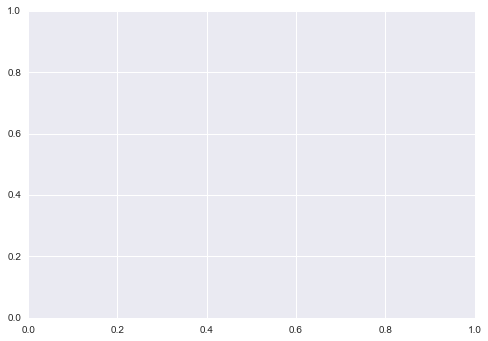

In [71]:
taxis = np.linspace(-100,100,20)
SWR_mean = []
FGB_mean = []
RND_mean = []
for ii,spkFile in enumerate(sorted([os.path.join(item[0],item[1]) for item in tools.locate('FiringUnits.spk',animalPath)])[:2]):
    print spkFile.split('/')[-3]
    spk = pkl.load(open(spkFile,'rb'))
    spk.changeTimeUnit('ms')
    t_bins = np.arange(0,np.math.ceil(spk.t_stop),10)
    binWidth = np.diff(t_bins)[0]
    print binWidth
    hst = np.zeros(t_bins.size-1)
    for zug in spk:
        hst += np.histogram(zug.spike_times,t_bins)[0]
    fRate = zScore(1e3*hst/binWidth)
    df = rippDB[rippDB.date=='day'+str(ii+1)]
    dfR = df[df.wc==300]
    dfG = df[df.wc==100]
    SWRfrates = np.zeros([dfR.shape[0],20])
    FGBfrates = np.zeros([dfG.shape[0],20])
    RNDfrates = np.zeros([dfG.shape[0],20])
    ii = -1
    for idx,row in dfR.iterrows():
        ii+=1
        try:
            peak_tIdx = tools.findNearest(t_bins,row.t_peak)[0]
            SWRfrates[ii,:]+=fRate[peak_tIdx-10:peak_tIdx+10]
        except ValueError:
            idx +=1
            #print 'Skipped %s' %ii
    sns.tsplot(SWRfrates,time=taxis)
    pl.plot(taxis,SWRfrates.mean(axis=0),label=spkFile.split('/')[-3].split('_')[-1] )
    pl.title(animal,fontsize=20)
    pl.legend()

0.892742023296 0.893120876003


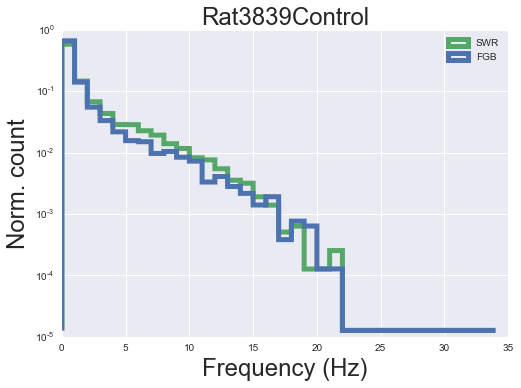

In [57]:
dfR = rippDB[rippDB.wc==300]
dfG = rippDB[rippDB.wc==100]
pl.hist([1.0/np.diff(dfG.t_peak/1e3),1.0/np.diff(dfR.t_peak/1e3)],np.arange(35),log=True,normed=True,histtype='step',lw=5,label=['FGB','SWR']);
pl.title(animal,fontsize=24)
pl.xlabel('Frequency (Hz)',fontsize=24)
pl.ylabel('Norm. count',fontsize=24)
pl.legend()
print 1.0/np.diff(dfG.t_peak/1e3).mean(),1.0/np.diff(dfR.t_peak/1e3).mean()

In [58]:
print FGcond.sum()/SWRcond.sum(),np.diff(dfR.t_peak/1e3).mean()/np.diff(dfG.t_peak/1e3).mean()
print (1e0*FGcond.sum()/SWRcond.sum())/(np.diff(dfR.t_peak/1e3).mean()/np.diff(dfG.t_peak/1e3).mean())

0 0.999575810267
0.996103979988


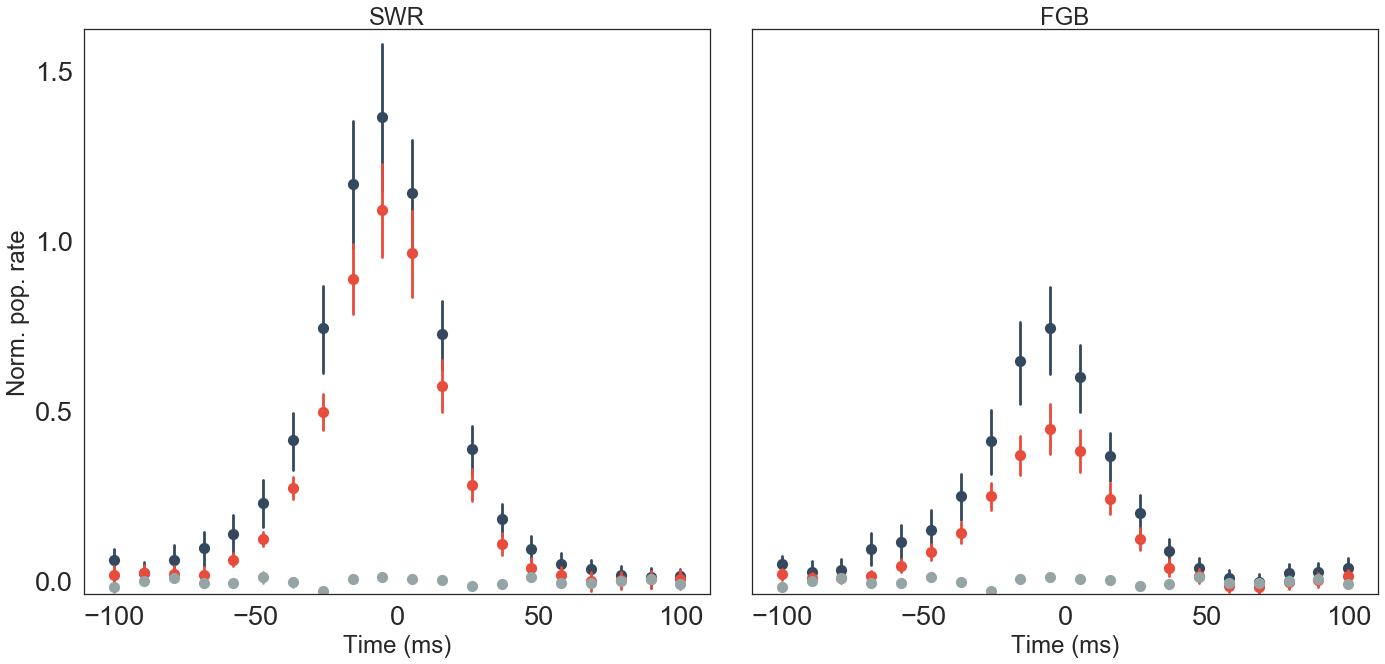

In [145]:
f,(ax,bx) = pl.subplots(1,2,figsize=[20,10],sharey=True)
controlRates = []
lesionRates = []
shuffledL = []
shuffledC = []
for pth in sorted([os.path.join(item[0],item[1]) for item in tools.locate('*SWR_mean.npArr','/home/chenani/ownCloud/IpythonNotebooks/')]):
    mtrx = pkl.load(open(pth,'rb'))
    if pth.find('ct/cont')>0:
        for ii in range(len(mtrx)):
            controlRates.append(mtrx[ii])
    else:
        for ii in range(len(mtrx)):
            lesionRates.append(mtrx[ii])
for pth in sorted([os.path.join(item[0],item[1]) for item in tools.locate('*RND_mean.npArr','/home/chenani/ownCloud/IpythonNotebooks/')]):
    mtrx = pkl.load(open(pth,'rb'))
    shuffledL.append(mtrx[ii])
sns.tsplot(controlRates,time=taxis,color=flatui[0],interpolate=False,err_style="ci_bars",ax=ax)
sns.tsplot(lesionRates,time=taxis,color=flatui[1],interpolate=False,err_style="ci_bars",ax=ax)
sns.tsplot(shuffledL,time=taxis,color=flatui[-1],interpolate=False,err_style="ci_bars",ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend()
ax.set_ylabel('Norm. pop. rate',fontsize=24)
ax.set_xlabel('Time (ms)',fontsize=24)
ax.set_title('SWR',fontsize=24)
ax.set_ylim([-0.03,1.63])
###############################################################################################
controlRates = []
lesionRates = []
for pth in sorted([os.path.join(item[0],item[1]) for item in tools.locate('*FGB_mean.npArr','/home/chenani/ownCloud/IpythonNotebooks/')]):
    mtrx = pkl.load(open(pth,'rb'))
    if pth.find('ct/cont')>0:
        for ii in range(len(mtrx)):
            controlRates.append(mtrx[ii])
    else:
        for ii in range(len(mtrx)):
            lesionRates.append(mtrx[ii])
for pth in sorted([os.path.join(item[0],item[1]) for item in tools.locate('*RND_mean.npArr','/home/chenani/ownCloud/IpythonNotebooks/')]):
    mtrx = pkl.load(open(pth,'rb'))
    shuffledL.append(mtrx[ii])
sns.tsplot(controlRates,time=taxis,color=flatui[0],interpolate=False,err_style="ci_bars",ax=bx)
sns.tsplot(lesionRates,time=taxis,color=flatui[1],interpolate=False,err_style="ci_bars",ax=bx)
sns.tsplot(shuffledL,time=taxis,color=flatui[-1],interpolate=False,err_style="ci_bars",ax=bx)
bx.set_xlabel('Time (ms)',fontsize=24)
bx.set_title('FGB',fontsize=24)
pl.tight_layout()
f.savefig('/home/chenani/ownCloud/Plots/Lesion-Project/SWR-FG-popRate-plot.pdf')

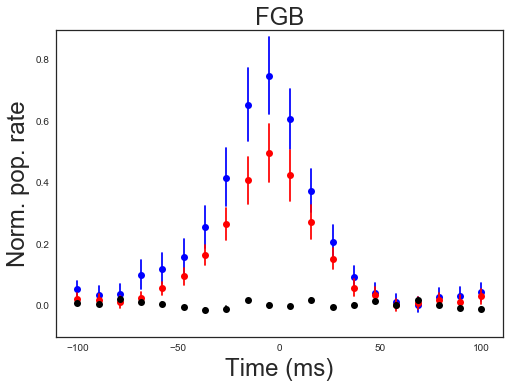

In [103]:
controlRates = []
lesionRates = []
for pth in sorted([os.path.join(item[0],item[1]) for item in tools.locate('*FGB_mean.npArr','/home/chenani/ownCloud/IpythonNotebooks/')]):
    mtrx = pkl.load(open(pth,'rb'))
    if pth.find('ct/cont')>0:
        for ii in range(len(mtrx)):
            controlRates.append(mtrx[ii])
    else:
        for ii in range(len(mtrx)):
            lesionRates.append(mtrx[ii])
for pth in sorted([os.path.join(item[0],item[1]) for item in tools.locate('*RND_mean.npArr','/home/chenani/ownCloud/IpythonNotebooks/')]):
    mtrx = pkl.load(open(pth,'rb'))
    shuffledL.append(mtrx[ii])
sns.tsplot(controlRates,time=taxis,color='b',interpolate=False,err_style="ci_bars")
sns.tsplot(lesionRates,time=taxis,color='r',interpolate=False,err_style="ci_bars")
sns.tsplot(shuffledL,time=taxis,color='k',interpolate=False,err_style="ci_bars")
pl.ylabel('Norm. pop. rate',fontsize=24)
pl.xlabel('Time (ms)',fontsize=24)
pl.title('FGB',fontsize=24)